# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

1.1. Загрузили датасет в среду

In [3]:
print(df.head())
df.info()

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

1.2. Сразу видно большое количество пропусков 

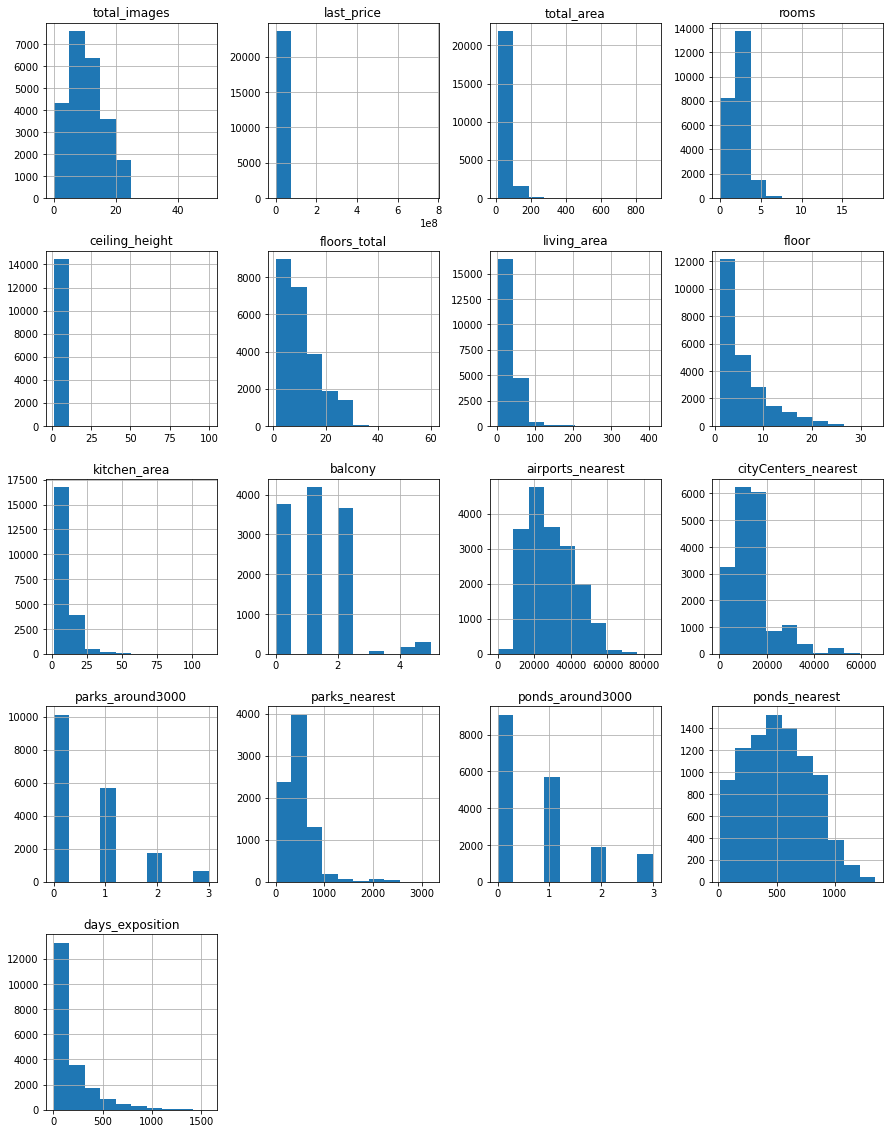

In [4]:
df.hist(figsize=(15, 20));

1.3. С первого взгляда при таком значении 'bins' подозрительных выбросов не обнаружено, правда странно выглядит гистограмма last_price, при таком масштабировании совершенно не понятно, что за ней скрывается.

### Предобработка данных

2.1. Ищем пропущенные значения.

In [4]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Начнём по порядку:**
**2.1.1.** ceiling_height К сожалению такие данные никак косвенно не востановить и придётся использовать медиану.
**2.1.2.** floors_total 86 значений можем позволить себе не учитывать, избавляемся от строк с ними 
**2.1.3.** living_area Можно вывести примерную площадь математически по формуле (total_area - kitchen_area)
**2.1.4.** is_apartment Учитывая что другие две опции (open_plan и studio) заполнены везде верно, можно смело везде ставить True, если нет противоречащих значений в open_plan и studio.
**2.1.5.** kitchen_area Так же математически выводим по формуле living_area * 0.9 - living_area
**2.1.6.** balcony Определить количество балконов по цифрам не выйдет, поэтому поставим 0
**2.1.7.** locality_name Такие данные не востановить и 49 строк не скажутся на нашей выборке
**2.1.8.** Группу значений растояния трогать не будем, оставим пропущенные значения, а в группе объектов поставим 0. 
**2.1.9.** days_exposition Думаю можно взять медианное значение и прибавить его к first_day_exposition        

**2.1.1. ceiling_height**

В соответствии с планом ищем медиану. Сначала проверим данные.

In [5]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Судя по максимальному значению некоторые данные перенесены неверно и скорее всего имелось в виду значение в десять раз меньше. Проверим сколько всего квартир в датасете имеют высоту потолков больше 10 метров (предположим, что такие уникумы существуют в категории опенспейс планеровок).

In [6]:
df_big_ceiling = df.query('ceiling_height > 10')
print(len(df_big_ceiling['ceiling_height']))
df_big_ceiling.head()

25


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0


Двадцать пять значений, кажется, немного, да и на статичтику не сильно влияет судя по describe,так что смело подсталяем медиану.  

In [7]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
print(df['ceiling_height'].isna().sum())
df.head()

0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Тема потолков пока что закрыта.

**2.1.2. floors_total**

In [8]:
#df = df.dropna(subset=['floors_total'])
df['floors_total'].isna().sum() 
#К сожалению синтетически смоделировать этажность не выйдет, пока оставим пропущеные данные.

86

**2.1.3. living_area**

In [9]:
df_l_a = df[df['living_area'].isna()]
df_l_a['kitchen_area'].isna().sum()

1464

Строк в которых нет ни living_area ни в kitchen_area 1464, к сожалению придётся эти данные никак искусственно не смоделировать.

In [10]:
#for t in df.index:
#    df.loc[df['living_area'].isna(), 'living_area'] = \
#    df.loc[df['living_area'].isna(), 'total_area'] - df.loc[df['living_area'].isna(), 'kitchen_area']
#df['living_area'].isna().sum()

In [11]:
df.loc[df['living_area'].isna(), 'living_area'] = \
df.loc[df['living_area'].isna(), 'total_area'] - df.loc[df['living_area'].isna(), 'kitchen_area']
df['living_area'].isna().sum()


1464

In [12]:
df[df['living_area'].isna()].head() 
#Проверяем. Кстати интерестные строки обнаружились 30 и 37, как "много" в них данных, удивительно.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9.0,NaN,2,NaN,...,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,...,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,NaN,3,NaN,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.65,13.0,NaN,13,NaN,...,NaN,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0


На этом оставим столбец living_area.

**2.1.4. is_apartment**

In [13]:
df_i_a = df[df['is_apartment'].isna()]
print(len(df_i_a))
print(len(df_i_a.query('studio == False')))
print(len(df_i_a.query('studio == False').query('open_plan == True')))
print(len(df_i_a.query('open_plan == False')))
print(len(df_i_a.query('open_plan == False').query('studio == True')))
print(len(df_i_a.query('open_plan == False').query('studio == False')))

20924
20790
60
20864
134
20730


Получается на все пропущенные is_apartment у нас 60 open_plan и 131 studio. Заполним оставшиеся значений на True

In [14]:
df.loc[(df['open_plan'] == False) & (df['studio'] == False) & (df['is_apartment'].isna()), 'is_apartment'] = True
df.loc[((df['open_plan'] == True) | (df['studio'] == True)) & (df['is_apartment'].isna()), 'is_apartment'] = False
df['is_apartment'].isna().sum()

0

**2.1.5. kitchen_area**

In [15]:
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = \
df.loc[df['kitchen_area'].isna(), 'total_area'] - df.loc[df['kitchen_area'].isna(), 'living_area']
df['living_area'].isna().sum()

1464

Получились те же злополучные 1464, значит всё сделано правильно. Пока оставим их в покое, хотя и смущает что у нас ~6% данных такого качества, с другой стороны всегда можно их выбросить.

**2.1.6. balcony**

In [16]:
df['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Смело заменяем на 0.

In [17]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].isna().sum()

0

**2.1.7. locality_name**

In [18]:
#df = df.dropna(subset=['locality_name'])
df['locality_name'].isna().sum()
#Такая же ситуация как и с количеством этажей

49

**2.1.8. Географические данные**

In [19]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
print(df['parks_around3000'].isna().sum())
print(df['ponds_around3000'].isna().sum())

0
0


**2.1.9. days_exposition**

In [20]:
#Первым делом переведем тип данных first_day_exposition в datetime.
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
#После поменяем тип данных для days_exposition на int64
#df['days_exposition'] = df['days_exposition']
#import datetime
#Теперь циклом прибавим к совпадающим значениям даты публикации известный нам по другим строкам срок расмещения.
#for d in df['first_day_exposition'].unique():
#    d_total = df.loc[(df['first_day_exposition'] == d), 'days_exposition'].median()
#    delta = datetime.timedelta(days=float(d_total))
#    #df.loc[(df['first_day_exposition'] == d) & (df['days_exposition'].isna()), 'days_exposition'] = d + delta
#К сожалению красивая задумка не прошла, вернусь к первоначальному плану
#for d in df['first_day_exposition'].unique():
#    df.loc[(df['first_day_exposition'] == d) & (df['days_exposition'].isna()), 'days_exposition'] = \
#    df.loc[(df['first_day_exposition'] == d), 'days_exposition'].median()
#Этот способо так же не прошел. Тогда оставлю пока данные в таком виде.

**2.2.**

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           22235 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          22235 non-null  float64       
 13  balcony         

Учитывая, что datetime мы перевели до этого, а float64 ранее не хотел ни в какую переходить в int64, и как список апартаментов превратить в bool мне не помог узнать даже интернет, не думаю, что стоит чтото менять 

**2.3**

In [22]:
display(df['locality_name'].unique())
df['locality_name'].nunique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

364

In [23]:
df['test_locality_name'] = df['locality_name'].str.replace('поселок городского типа ','') \
    .str.replace('посёлок городского типа ','').str.replace('садовое товарищество ','') \
    .str.replace('коттеджный посёлок ','').str.replace('коттеджный поселок ','').str.replace('городской поселок ','') \
    .str.replace('городской посёлок ','').str.replace('садоводческое некоммерческое товарищество ','') \
    .str.replace('посёлок ','').str.replace('село ','').str.replace('поселок ','').str.replace('деревня ','') \
    .str.replace('деревня ','').str.replace('деревня ','').str.replace('пок ','').str.replace('при железнодорожной станции ','') \
    .str.replace('пок станции ','')
df['test_locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [24]:
#Данные нас устраивают заменяем столбец
df['locality_name'] = df['test_locality_name']
df.drop(labels='test_locality_name', axis=1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,True,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.60,1,True,...,11.00,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.30,4,True,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,True,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,True,...,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.30,3,True,...,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.00,4,True,...,8.50,0.0,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.70,1,True,...,27.00,0.0,Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,53.45,12,True,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


In [25]:
df['locality_name'].nunique() #Дубли покинули чат

308

**2.4**

In [26]:
def helper(row):
    print(row.describe())
    print(row.quantile(0.995)) #верхнее значение начала хвоста
    print(row.quantile(0.005)) #нижнее значение начала хвоста
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'test_locality_name'],
      dtype='object')

In [27]:
helper(df['total_area'])

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64
248.85299999999953
23.5


In [28]:
df_test = pd.concat([df[df['total_area'].isna()],  
                df[df['total_area'].notna()].query('23.5 < total_area < 248.75')], ignore_index=True)
df_test['total_area'].describe() 

count    23460.000000
mean        59.126301
std         28.654001
min         23.550000
25%         40.000000
50%         52.000000
75%         69.300000
max        248.700000
Name: total_area, dtype: float64

In [29]:
#Видим, что ничего криминального с точки зрения статичтики не поменялось, значит можем применять изменения к основному массиву.
df = pd.concat([df[df['total_area'].isna()],  
                df[df['total_area'].notna()].query('23.5 < total_area < 248.75')], ignore_index=True)

In [30]:
helper(df['rooms'])

count    23460.000000
mean         2.057161
std          1.023871
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64
6.0
0.0


In [31]:
# 0 Комнат интересно
len(df.query('rooms == 0'))

163

In [32]:
# 160 квартир состоящих видимо исключительно из одной двери, возможно это студии или квартиры с открытой планировкой? 
print(len(df.query('rooms == 0').query('is_apartment  == True')))
print(len(df.query('rooms == 0').query('open_plan  == True')))
print(len(df.query('rooms == 0').query('studio  == True')))

0
51
112


In [33]:
#Всё сходится значит нижнее значение отнимать нельзя, займёмся верхним.
df_test = pd.concat([df[df['rooms'].isna()],  
                df[df['rooms'].notna()].query('rooms <= 6.0')], ignore_index=True)
df_test['rooms'].describe()

count    23411.00000
mean         2.04562
std          0.99149
min          0.00000
25%          1.00000
50%          2.00000
75%          3.00000
max          6.00000
Name: rooms, dtype: float64

In [34]:
#Всё в порядке, применяем изменения.
df = pd.concat([df[df['rooms'].isna()],  
                df[df['rooms'].notna()].query('rooms <= 6.0')], ignore_index=True)

In [35]:
helper(df['ceiling_height'])

count    23411.000000
mean         2.721564
std          0.992517
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64
3.9
2.5


In [36]:
#Очень высокие потолки с 30-и этажный дом, интересно сколько таких?
print(len(df.query('ceiling_height > 3.9'))) #Возьмем за максимум высоту потолков в зимнем дворце
# Предположим что кто-то перепутал метрики и забыл поставить запятую, тогда исправим данные для тех у кого высота потолка равна
# десяти медианам 
for t in df.index:
    df.loc[(df['ceiling_height'] > 26), 'ceiling_height'] = \
    df.loc[(df['ceiling_height'] > 26), 'ceiling_height'] / 10 
helper(df['ceiling_height'])

112
count    23411.000000
mean         2.705898
std          0.531035
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         26.000000
Name: ceiling_height, dtype: float64
3.8285000000000218
2.5


In [37]:
#Всё в порядке применяем к основному датасету
#df = df[(df['ceiling_height'] > 2.5)]
#df = df[(df['ceiling_height'] < 3.2)]
df = pd.concat([df[df['ceiling_height'].isna()],  
                df[df['ceiling_height'].notna()].query('2.5 < ceiling_height < 3.2')], ignore_index=True)

In [38]:
helper(df['last_price'])
df['last_price'].min()
#значения напрягают, с другой стороны для дома в деревне 809500 вполне реальная цена. 
#(только что на циане посмотрел для лен области) так что можно отбросить значения ниже этого порога.
#верхний порог трогать не будем
df = pd.concat([df[df['last_price'].isna()],  
                df[df['last_price'].notna()].query('37000000 > last_price > 809500')], ignore_index=True)

count    1.882600e+04
mean     6.125009e+06
std      5.757032e+06
min      1.219000e+04
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      1.600000e+08
Name: last_price, dtype: float64
37000000.0
820000.0


In [39]:
helper(df['living_area'])

count    17443.000000
mean        33.139757
std         17.339956
min          2.000000
25%         18.500000
50%         30.000000
75%         42.000000
max        228.060000
Name: living_area, dtype: float64
106.31600000000036
11.384200000000002


In [40]:
df_test = pd.concat([df[df['living_area'].isna()],  
                df[df['living_area'].notna()].query('11.5 < living_area < 110.4')], ignore_index=True)
df_test['living_area'].describe()

count    17276.000000
mean        32.846184
std         16.035173
min         11.600000
25%         18.600000
50%         30.000000
75%         42.000000
max        110.300000
Name: living_area, dtype: float64

In [41]:
df = pd.concat([df[df['living_area'].isna()],  
                df[df['living_area'].notna()].query('11.5 < living_area < 110.4')], ignore_index=True)

In [42]:
helper(df['kitchen_area'])

count    17276.000000
mean        10.915718
std          5.654651
min          0.000000
25%          7.935000
50%         10.000000
75%         12.000000
max        117.900000
Name: kitchen_area, dtype: float64
40.2
5.0


In [43]:
df_test = pd.concat([df[df['kitchen_area'].isna()],  
                df[df['kitchen_area'].notna()].query('5 < kitchen_area < 42')], ignore_index=True)
df_test['kitchen_area'].describe()

count    16890.000000
mean        10.848748
std          4.910846
min          5.040000
25%          8.000000
50%         10.000000
75%         12.000000
max         41.200000
Name: kitchen_area, dtype: float64

In [44]:
df = pd.concat([df[df['kitchen_area'].isna()],  
                df[df['kitchen_area'].notna()].query('5 < kitchen_area < 42')], ignore_index=True)

Пока чистил данные задумался, что было бы неплохо свести тип жилплощади из трех столбцов в один, но исследование этого не требует. Учитывая географию списка, на самом деле не удивительно было встретить дом с площадью 900 квм, за городом и не такой особняк можно отгрохать.

### Добавляем необходимые столбцы

In [45]:
#Проверяем наличие данных
print(df['total_area'].isna().sum())
print(df['last_price'].isna().sum())
#Все данные на месте
df['m_price'] = df['last_price'] / df['total_area']
df.head(2) #Всё верно

0
0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,test_locality_name,m_price
0,12,2200000.0,32.8,2018-02-19,1,2.65,9.0,NaN,2,True,...,Коммунар,NaN,NaN,0.0,NaN,0.0,NaN,63.0,Коммунар,67073.170732
1,13,5350000.0,40.0,2018-11-18,1,2.65,22.0,NaN,3,True,...,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN,Санкт-Петербург,133750.000000


In [46]:
#Проверяем наличие данных
print(df['first_day_exposition'].isna().sum())
#Все данные на месте
#Пять минут гугла и была обнаружена замечательная функция
df["day_exposition"] = df["first_day_exposition"].dt.dayofweek
df["month_exposition"] = df["first_day_exposition"].dt.month
df["year_exposition"] = df["first_day_exposition"].dt.year
df.head()

0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,test_locality_name,m_price,day_exposition,month_exposition,year_exposition
0,12,2200000.0,32.8,2018-02-19,1,2.65,9.0,NaN,2,True,...,0.0,NaN,0.0,NaN,63.0,Коммунар,67073.170732,0,2,2018
1,13,5350000.0,40.0,2018-11-18,1,2.65,22.0,NaN,3,True,...,1.0,620.0,1.0,1152.0,NaN,Санкт-Петербург,133750.000000,6,11,2018
2,15,6300000.0,46.5,2017-03-06,1,2.65,13.0,NaN,13,True,...,0.0,NaN,0.0,NaN,336.0,Санкт-Петербург,135483.870968,0,3,2017
3,3,2740000.0,35.0,2018-01-01,1,2.65,12.0,NaN,8,True,...,0.0,NaN,0.0,NaN,11.0,Мурино,78285.714286,0,1,2018
4,9,10949000.0,68.0,2018-12-27,1,2.65,10.0,NaN,6,True,...,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,161014.705882,3,12,2018


In [47]:
#Задаем новый столбец. 
df["floor_category"] = ["other"]*len(df)
#Переписываем ячейки в соответсвии с условием
df.loc[df["floor"] == 1, "floor_category"] = "first"
df.loc[df["floor"] == df["floors_total"], "floor_category"] = "last"
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,test_locality_name,m_price,day_exposition,month_exposition,year_exposition,floor_category
0,12,2200000.0,32.8,2018-02-19,1,2.65,9.0,NaN,2,True,...,NaN,0.0,NaN,63.0,Коммунар,67073.170732,0,2,2018,other
1,13,5350000.0,40.0,2018-11-18,1,2.65,22.0,NaN,3,True,...,620.0,1.0,1152.0,NaN,Санкт-Петербург,133750.000000,6,11,2018,other
2,15,6300000.0,46.5,2017-03-06,1,2.65,13.0,NaN,13,True,...,NaN,0.0,NaN,336.0,Санкт-Петербург,135483.870968,0,3,2017,last
3,3,2740000.0,35.0,2018-01-01,1,2.65,12.0,NaN,8,True,...,NaN,0.0,NaN,11.0,Мурино,78285.714286,0,1,2018,other
4,9,10949000.0,68.0,2018-12-27,1,2.65,10.0,NaN,6,True,...,NaN,0.0,NaN,NaN,Санкт-Петербург,161014.705882,3,12,2018,other


In [48]:
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest'] / 1000)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,test_locality_name,m_price,day_exposition,month_exposition,year_exposition,floor_category,cityCenters_nearest_km
0,12,2200000.0,32.8,2018-02-19,1,2.65,9.0,NaN,2,True,...,0.0,NaN,63.0,Коммунар,67073.170732,0,2,2018,other,NaN
1,13,5350000.0,40.0,2018-11-18,1,2.65,22.0,NaN,3,True,...,1.0,1152.0,NaN,Санкт-Петербург,133750.000000,6,11,2018,other,12.0
2,15,6300000.0,46.5,2017-03-06,1,2.65,13.0,NaN,13,True,...,0.0,NaN,336.0,Санкт-Петербург,135483.870968,0,3,2017,last,15.0
3,3,2740000.0,35.0,2018-01-01,1,2.65,12.0,NaN,8,True,...,0.0,NaN,11.0,Мурино,78285.714286,0,1,2018,other,NaN
4,9,10949000.0,68.0,2018-12-27,1,2.65,10.0,NaN,6,True,...,0.0,NaN,NaN,Санкт-Петербург,161014.705882,3,12,2018,other,NaN


### Исследовательский анализ данных

In [49]:
import matplotlib.pyplot as plt
#Создаём функцию для простоты
def reserch_col(x: pd.Series):
    plt.figure()
    plt.hist(x, edgecolor="black", bins=25)
    plt.grid()
    print(x.describe())
    

count    18079.000000
mean        58.030683
std         24.474577
min         23.550000
25%         40.000000
50%         52.500000
75%         70.000000
max        240.000000
Name: total_area, dtype: float64


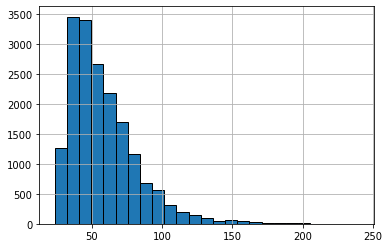

In [50]:
reserch_col(df['total_area'])

Из гистограммы можно сделать вывод, что большая часть квартир на рынке одно и двухкомнатные (если опираться на нормы СНиП). 

count    16890.000000
mean        32.845390
std         16.014683
min         11.600000
25%         18.600000
50%         30.000000
75%         42.000000
max        110.300000
Name: living_area, dtype: float64


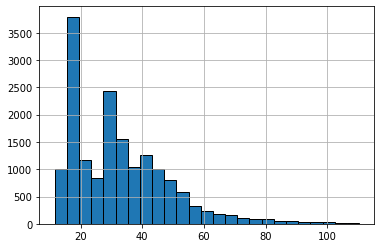

In [51]:
reserch_col(df['living_area'])

На гистограмме четко видны два значения которые наиболе часто встречаются, экстраполируя это на нормы СПиН это подверждает наши выводы по первой гистограмме. 

count    16890.000000
mean        10.848748
std          4.910846
min          5.040000
25%          8.000000
50%         10.000000
75%         12.000000
max         41.200000
Name: kitchen_area, dtype: float64


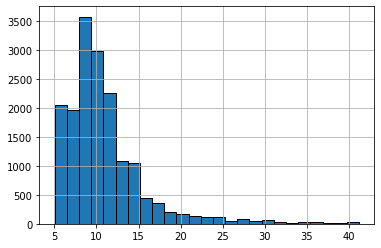

In [52]:
reserch_col(df['kitchen_area'])

Гистограмма демонстрирует нам, что площадь кухни не растет так же стримительно как и жилплощадь в след за 'комнатностью' квартиры, и что наиболее частым размером кухни является 10квм 

count    1.807900e+04
mean     5.835782e+06
std      3.999226e+06
min      8.200000e+05
25%      3.549000e+06
50%      4.750000e+06
75%      6.785000e+06
max      3.675000e+07
Name: last_price, dtype: float64


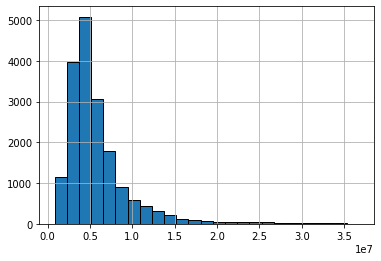

In [53]:
reserch_col(df['last_price'])

In [54]:
#Не самый дружелюбный для восприятия график благодаря масштабу, потому дополнительно вызовем медиану и среднее арифметическое.
print(df['last_price'].median())
print(df['last_price'].mean())

4750000.0
5835782.416671276


Гистограмма показывает нам, что большинство значений находится в диапазоне до 0.1(1е8), то есть до 10 млн, что перекликается с первой гистограммой метража (1-2 комнтатные помещения).

count    18079.000000
mean         1.986504
std          0.950387
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64


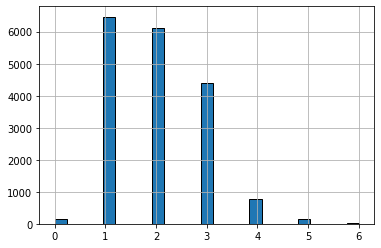

In [55]:
reserch_col(df['rooms'])

Данная гистограмма подветрждает наши прошлые выводы что самые часто встречаемые форматы квартир одно и двухкомнатные, 5 и 6 комнат характерны для закогордной недвижимости. 

count    18079.000000
mean         2.690730
std          0.118922
min          2.510000
25%          2.650000
50%          2.650000
75%          2.700000
max          3.180000
Name: ceiling_height, dtype: float64


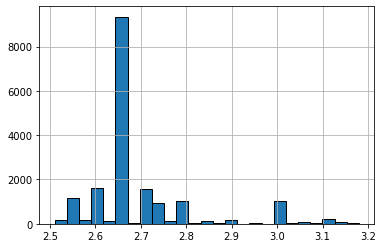

In [56]:
reserch_col(df['ceiling_height'])

Гистограмма показывает, что высота потолков строго по СНиП, и снова значения выше в загородном частном секторе, где индивидуальное строительство, и застройщик не стремится свести к минимуму затраты на квм. 

count    18079.000000
mean         6.349577
std          5.176050
min          1.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         33.000000
Name: floor, dtype: float64


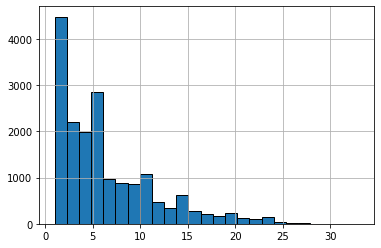

In [57]:
reserch_col(df['floor'])

На лицо наследие 1844 года с запретом на высотное строительство, так же сказываются прошлые застройки советское эпохи, всё это нам демонстрирует гистограмма перепадом между 4 и 5 этажными предложениями. Так же большое предложение квартиры на первом этаже, но это связано в первую очередь с тем, что на них сложнее найти покупателя. 

count     18079
unique        3
top       other
freq      13699
Name: floor_category, dtype: object


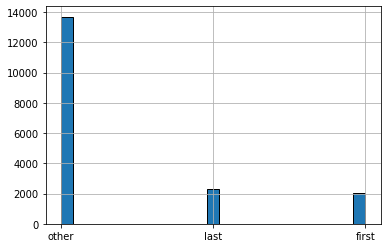

In [58]:
reserch_col(df['floor_category'])

In [59]:
df.pivot_table(index='floor_category', values='days_exposition', aggfunc=('median','mean'))

,mean,median
floor_category,,
first,204.175942,116.0
last,188.994036,99.0
other,173.204295,91.0


Как правило на первом и последнем этаже меньше желающих жить, а последний этаж, к которому зачастую любыми способами стараются присовокупить крышу или пристроить мансарду, к тому же еще и мало желающих продать, что и отображает наша сводная таблица. Первый и последний этаж в среднем продается на 10-30 дней дольше.

count    18002.000000
mean        11.654872
std          6.862627
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


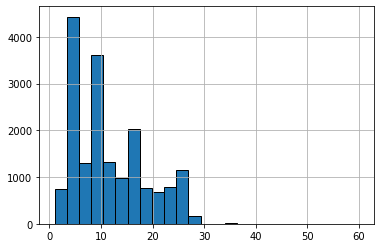

In [60]:
reserch_col(df['floors_total'])

Указ 1844 года (первый столбец 4-5 этажей), плановая застройка советской эпохи (второй столбец 9-10 этажей) и современная массовая застройка (третий столбец 15-16 этажей) наглядно видны на графике. 

count    13906.000000
mean     14364.601970
std       8156.147147
min        318.000000
25%       9893.250000
50%      13265.000000
75%      16315.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


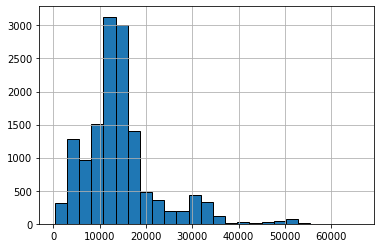

In [61]:
reserch_col(df['cityCenters_nearest'])

Вот это уже похоже на нормальное распределение, так как желание продать квартиру никак от растояния до центра не зависит. От расстояния от центра зависит то как далеко от исторической застройки находится недвижимость, иными словами плотность застройки, что и демонстрирует нам гистограмма.  

count    13888.000000
mean     28739.788090
std      12508.571772
min          0.000000
25%      18462.000000
50%      27313.500000
75%      36897.000000
max      84869.000000
Name: airports_nearest, dtype: float64


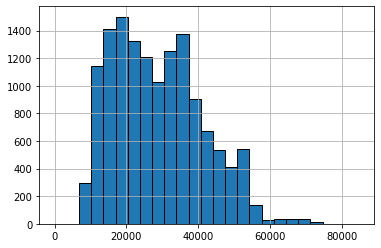

In [62]:
reserch_col(df['airports_nearest'])

Гистограмма очередной раз намекает нам, что приаэродромная территория имеет особый правовй статус и строительство в таких зонах строго регулируется. Об этом говорит резкий перепад в районе 4 километров после, которого законом разрешено жилищное строительство возле аэропортов.

count    5890.000000
mean      505.753820
std       363.481176
min         1.000000
25%       293.000000
50%       459.000000
75%       623.000000
max      3190.000000
Name: parks_nearest, dtype: float64


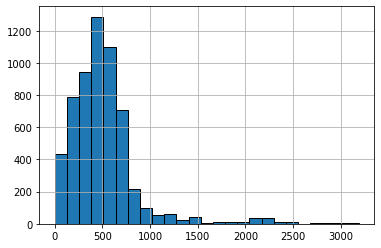

In [63]:
reserch_col(df['parks_nearest'])

Если парк рядом с квартирой есть, то он либо рядом, либо его нет.

count    18079.000000
mean         2.591736
std          1.788236
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_exposition, dtype: float64


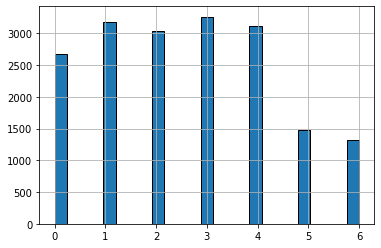

In [64]:
reserch_col(df['day_exposition'])

Скорее всего такая разница в активности между будними и выходными связана с тем кто размешает объявления, по выходным риэлторы отдыхают, отсюда и разница.

count    18079.000000
mean         6.429780
std          3.490434
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64


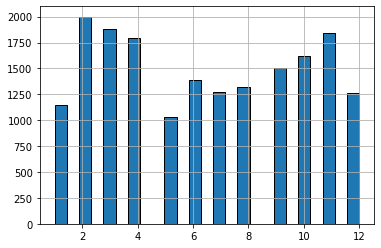

In [65]:
reserch_col(df['month_exposition'])

Гистограмма демонстрирует туристический характер Санкт-Петербурга, маленькое количество новых объявлений в летний и зимний период можно объестнить периодом каникул, возврастание же предложений в осенне-весенний снижением туристического интереса.

**4.2 Время "жизни" объявления.**

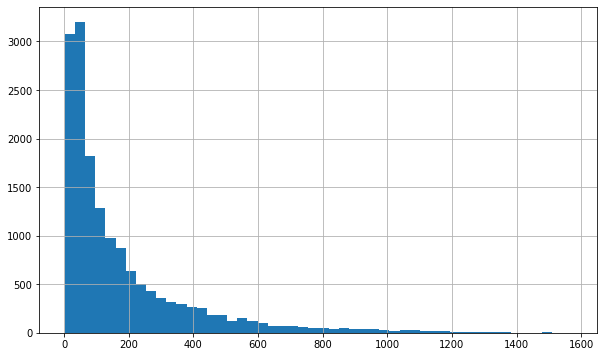

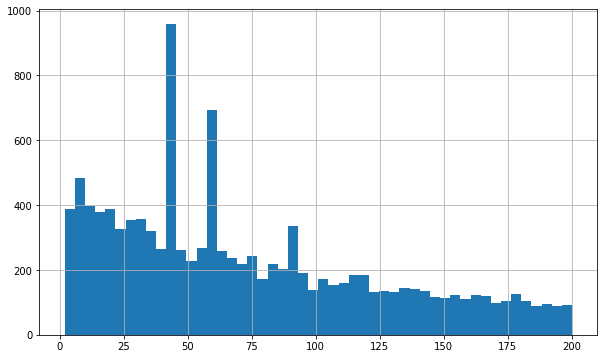

count    15945.000000
mean       178.652242
std        217.504753
min          2.000000
25%         45.000000
50%         94.000000
75%        227.000000
max       1572.000000
Name: days_exposition, dtype: float64

In [66]:
df['days_exposition'].hist(bins=50, figsize=(10, 6))
plt.show()
df['days_exposition'].hist(bins=50, figsize=(10, 6), range=(2,200))
plt.show()
df['days_exposition'].describe()

Классическое распределение Пуассона. Как бы не было удивительно, но большая часть продаж происходит в первые полгода, если за это время покупатель не нашелся, значит нужно срочно что-то менять, инчае есть все шансы просидеть пять лет как рекордсмен из нашего датафрейма. Те кто сумел совершить продажу в течении первых полутра месяцев, можно назвать успешными продажниками и попытаться чему-то научиться у них , в то время как некоторые и за 8 месяцев не смогли передать квартиру в надежные руки, что можно назвать долгой продажей, как мы помним по прошлым графикам раз в полгода количество желающих приобрести жильё в Лен области значительно возврастает. 

**4.3 Факторы влияющие на стоймость квратиры.**

In [67]:
#Для удобства сделаем фунцию
def we_r_plottin(z):
    df.plot(x='last_price', y=z, kind='scatter')
    print(df['last_price'].corr(df[z]))

**Кореляция цены иобщей площади.**

0.7672803943942853


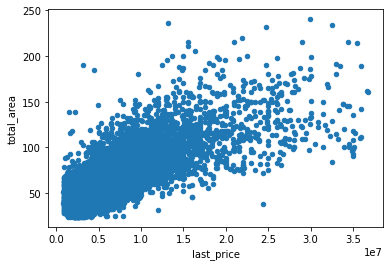

In [69]:
we_r_plottin('total_area')

Коэффициент корреляции 0.7 чуть-чуть не дотянул до 0.75, тем не менее это достаточно сильный показатель. Можно смело утверждать, что цена квартиры напрямую зависить от её площади.
***
**Кореляция цены и жилой площади.**

0.6469954727542849


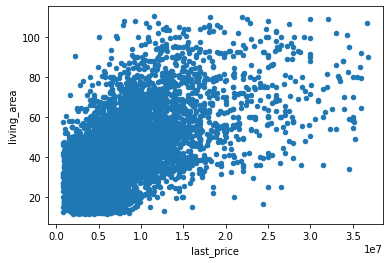

In [70]:
we_r_plottin('living_area')

Коэффициент корреляции 0.61 слабее чем прошлый, но всё ещё прослеживается определенная связь. Больше жилплощадь, выше цена.
***
**Кореляция цены и площади кухни.**

0.5276776172641472


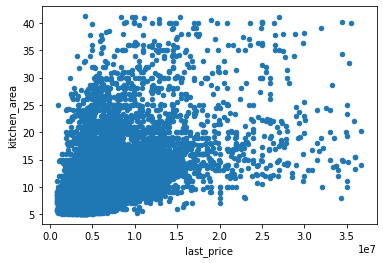

In [71]:
we_r_plottin('kitchen_area')

Коэффициент корреляции 0.48 еще слабее чем прошлый, но это связано с тем что размер кухни, как правило, не растет вместе с размером квартиры. Сохраняется средняя положительная корреляция. 
***
**Кореляция цены и числа комнат.**

,mean,median,count
rooms,,,
0,3.106486e+06,2952500.0,145
1,3.953799e+06,3700000.0,6466
2,5.680104e+06,4999999.5,6116
3,7.791331e+06,6450000.0,4392
4,1.048641e+07,8700000.0,787
5,1.293337e+07,11145000.0,146
6,1.441817e+07,12990000.0,27


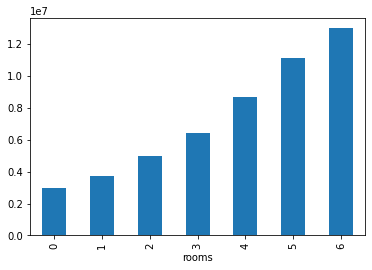

In [72]:
df.groupby('rooms')['last_price'].agg('median') \
    .plot(x='rooms', y='median', kind='bar') 
df.groupby('rooms')['last_price'].agg(['mean', 'median', 'count'])

График не оставляет пространства для мышления, однозначная прямая зависимость цены от количества комнат.
***
**Влияние этажа на цену**

<AxesSubplot:xlabel='floor_category'>

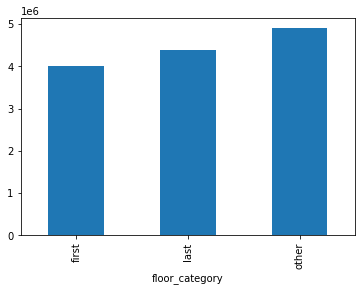

In [73]:
df.groupby('floor_category')['last_price'].agg('median') \
    .plot(x='floor_category', y='median', kind='bar') 

Квартиры на последнем этаже имеют тенденцию делать мансардами, порой добавлять чердак, в общем любыми способами увеличивать их площадь, так же для последнего этажа в случае Санкт-Петербурга можно сделать наценку за счет вида. Квартиры же на первом этаже имеют плохой спрос, так как не каждый готов ставить решетки на окна или жить в постоянном опасении что ему в окно кто-то влезет, плюс шумовое и световое загрязнение в городе, так же отпугивают покупателей, из-за чего продавец вынуждено снижает цену.
***
**Влияние дня недели публикации на цену**

,mean,median,count
day_exposition,,,
0,5.892550e+06,4775000.0,2674
1,5.874343e+06,4850000.0,3186
2,5.937862e+06,4800000.0,3039
3,5.848673e+06,4750000.0,3262
4,5.794139e+06,4670000.0,3111
5,5.627871e+06,4650000.0,1480
6,5.692859e+06,4626540.0,1327


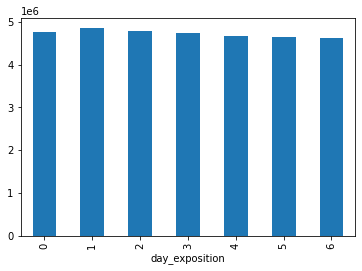

In [74]:
df.groupby('day_exposition')['last_price'].agg('median') \
    .plot(x='day_exposition', y='median', kind='bar') 
df.groupby('day_exposition')['last_price'].agg(['mean', 'median', 'count'])

Как мы выяснили ранее, в буднии дни по мимо обычных пользователей объявления выкладывают и риэлторы. Можно было бы предположить, что тогда в выходные дни были бы неоправдано высокие цены так как продажами занимаются не профессионалы, но мы этого не видим. В целом график показывает нам, что цена от дня недели публикации не зависит. 
***
**Влияние месяца публикации на цену**

,mean,median,count
month_exposition,,,
1,5.915730e+06,4799500.0,1147
2,5.814589e+06,4769000.0,1999
3,5.800320e+06,4800000.0,1876
4,5.848844e+06,4950000.0,1797
5,5.774368e+06,4560000.0,1032
6,5.617719e+06,4500000.0,1390
7,5.711025e+06,4750000.0,1277
8,5.921780e+06,4700000.0,1320
9,5.985821e+06,4800000.0,1505


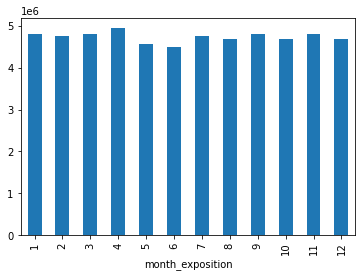

In [75]:
df.groupby('month_exposition')['last_price'].agg('median') \
    .plot(x='month_exposition', y='median', kind='bar') 
df.groupby('month_exposition')['last_price'].agg(['mean', 'median', 'count'])

Хоть есть незначительное понижение в в летне-зимний период, но как и в случае с днем публикации месяц публикации слабо влияет на стоймость.
***
**Влияние года публикации на цену**

,mean,median,count
year_exposition,,,
2014,1.005666e+07,7868500.0,112
2015,6.472239e+06,5250000.0,947
2016,5.768131e+06,4600000.0,2231
2017,5.652778e+06,4550000.0,6546
2018,5.740857e+06,4700000.0,6270
2019,6.276027e+06,5300000.0,1973


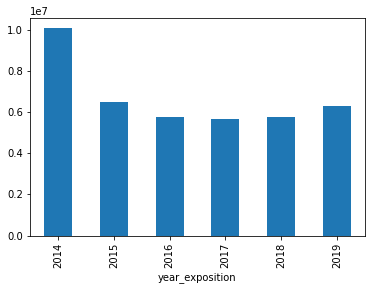

In [76]:
df.groupby('year_exposition')['last_price'].agg('mean') \
    .plot(x='year_exposition', y='median', kind='bar') 
df.groupby('year_exposition')['last_price'].agg(['mean', 'median', 'count'])

Год публикации в свою очередь сильно влияет на стоймость, так как тут чаще вступают в работу макроэкономические показатели и внешние факторы. Как известно недвижимость многими воспринимается как традиционный вид инвестиций и на фоне внешней нестабильности покупатель стремился конвертировать стримительно теряющий позиции рубль в квадратные метры. Это видно на графике, где пиковове значение приходится на 2014 год. В дальнейшем с развитием кризиса и падением как покупательской способности, так и уровня спроса, рынок отскочил, что выражается в падении цены. Со временем экономическая ситуация стабилизировалась, что отображено на графике ростом 2018-19.

**4.4 Ценность кв. метра в Лен. области.**

In [77]:
df['locality_name'].value_counts().head(10) #ищем самые популярные города
city = ['Санкт-Петербург','Мурино', 'Кудрово', 'Шушары', 'Всеволожск',
        'Парголово', 'Пушкин', 'Колпино', 'Гатчина', 'Петергоф'] #Создаем список с ними
city_m_price = []
for city_name in city: #Пишем цикл который посчитает нам значения
    df_temp = df.query('locality_name == @city_name')
    city_m_price.append(df_temp['m_price'].mean())

frame = pd.DataFrame({'city' : city,'city_m_price' : city_m_price}) #сводим в новый df
print(frame)
print(frame.min())
frame.max()

              city   city_m_price
0  Санкт-Петербург  111712.978358
1           Мурино   85312.642654
2          Кудрово   94926.820516
3           Шушары   77951.099712
4       Всеволожск   69084.539173
5        Парголово   90016.289647
6           Пушкин  104981.697905
7          Колпино   75546.742711
8          Гатчина   69467.060677
9         Петергоф   84759.582479
city              Всеволожск
city_m_price    69084.539173
dtype: object


city                   Шушары
city_m_price    111712.978358
dtype: object

Самый дешевый метр в Всеволожске, а дорогой в Шушарах.

**4.5 Средняя ценна квартиры в заисимости от отдаления от центтра**

<AxesSubplot:xlabel='km_list'>

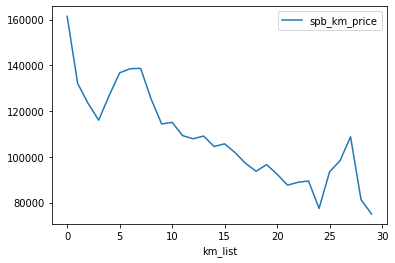

In [78]:
df_temp = df.query('locality_name == "Санкт-Петербург"') #Делаем срез по городу
df_temp['cityCenters_nearest_km'].unique() #Ищем цникальные значения 
km_list = sorted([16, 14,  8, 12, 11, 15, 13, 10,  2,  4, 17,  7,  5,
        9,  3,  6, 18,  1, 24, 26, 22, 20, 25, 21, 27,
       28, 19,  0, 23, 29])
spb_km_price = []
for km in km_list:
    df_temp = df.query('cityCenters_nearest_km == @km')
    spb_km_price.append(df_temp['m_price'].mean())

frame = pd.DataFrame({'km_list' : km_list,'spb_km_price' : spb_km_price})
frame.plot(x='km_list', y='spb_km_price')

Зависимость выгглядит логично, чем ближе к центру тем дороже квм, скачек на 7 км слабо объясним, возможно там был построен новый ЖК который поломал всю статистику, может быть это связано с тем что (если верить гугл картам) окружная находится на таком растоянии от центра. Так или иначе, но общая тенденция чем ближе к центру тем дороже сохраняется до самого конца. 

### Общий вывод

В ходе работы нами были подготовленны к исследованию предоставленные данные. Проведены исследование основных показателей. Изучена метрика скорости продаж и проверены факторы стоимости квм в Лен области, выявлена средняя стоимость квм в 10 самых популярных населенных пунктах области и проверена гипотеза зависимости стоимости квм от растояния до центра Санкт-Петербурга.

Мы узнали, что наиболее частый представитель на рынке это одно и двухкомнатные квартиры площадью до 70 метров. Больше всего квартир в ценовой категории до 20 млн рублей. Самые популярные дома 5, 10 и 16 этажные. Среднее время продажи квартиры составляет 100 дней. Хуже всего продаются квартиры на первом и последних этажах. Самое большое влияние на стоимость жилплощади имеет общая площадь объекта. Выяснено что в среднем в Лен области самый дешевый квм в Всеволожске, а самый дорогой в Шушарах. Так же была подверждена гипотеза, что в Санкт-Петерберге стоимость квм обратно пропорциональна растоянию до центра города. 

Просим в следующий раз выслать метрику по уже проданным квартирам, чтобы подтвердить гипотезу про разницу в спросе и предложении между летне-зимний периодом и осенне-весеннем, а так же предоставить данные по арендам, для более полного анализа рынка недвижимости. 
